# A Regression Playground

EECS 127

Version 1 - Sean Farhat (Sp 2020)

In this notebook, we will explore 4 different types of regression: Ordinary Least Squares, Ridge Regression, Weighted Least Squares, and Tikhonov Regularization. Only modify code in the sections marked TODO and fill in your answers to the questions marked TODO.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.font_manager import FontProperties
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
np.set_printoptions(3, suppress=True)
fontP = FontProperties()
fontP.set_size('small')

In [2]:
np.random.seed(42)

In [3]:
def data_fn(X):

    y = 1/1000*(X - 6)*(X - 4)*(X - 2)*(X + 1)*(X + 3)*(X + 5)*(X + 7)
    
    return y

In [4]:
def generate_data(m, n, poly_degree=1, generate_bad_data=False):

    X = np.linspace(-7, 6, m).reshape(-1, 1)
    
    y = data_fn(X)
    
    noise = np.random.normal(0, 2, size=X.shape[0]).reshape(-1, 1)
    y_obs = y + noise
    
    bad_noise = np.random.normal(0, 10, size=X.shape[0]).reshape(-1, 1)
    y_obs_bad = y + bad_noise
    
    # create polynomial features
    poly = PolynomialFeatures(degree=poly_degree)
    X_hat = poly.fit_transform(X)

    X_true = np.linspace(-7.1, 6.1, 1000).reshape(-1, 1)
    y_true = data_fn(X_true)
    
    X_hat_true = poly.fit_transform(X_true)
    
    # Note we are creating "test" data here, but this is really like a true error, since we have the underlying polynomial at hand
    # So even though we add some noise, this is a bit artificial
    y_test = data_fn(X) + np.random.normal(0, 2, size=X.shape[0]).reshape(-1, 1)
    
    return X_hat, X, X_hat_true, X_true, y_obs, y_obs_bad, y_true, y_test

In [5]:
def plot_result(X_hat, X, X_true, y_obs, y_true, y_test, ws, y_obs_bad=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    
    ax[0].set_title("Regression")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].grid()
    ax[0].scatter(X, y_obs, label="Observations", alpha=0.5, color="green", marker="+")
    ax[0].plot(X_true, y_true, label="Groud Truth", alpha=0.5, color="orange", linestyle="--")
    ax[0].scatter(X, y_test, label="Test Set", color="blue", alpha=0.5, marker="*")
    
    if y_obs_bad is not None:
        ax[0].scatter(X, y_obs_bad, label="Bad Observations", alpha=0.5, color="red", marker="x")
    
    for w, name in ws:
        ax[0].scatter(X, X_hat @ w, label=name)
    ax[0].legend(prop=fontP)

    ax[1].set_title("Visualizing w")
    ax[1].grid()
    
    for w, name in ws:
        ax[1].scatter(w[0][0], w[1][0], label=name)
    ax[1].legend()

# 0. Data Generation
Our data will be generated from some pre-defined function, but with some Gaussian/random noise added to it. Our goal will be to fit a 7-degree polynomial to this data. We have two sets of observations. "Good observations" are those which were collected with a small amount of noise, but "Bad observations" were collected with much more noise.

In [6]:
X_hat, X, X_hat_true, X_true, y_obs, y_obs_bad, y_true, y_test = generate_data(30, 1, poly_degree=7)

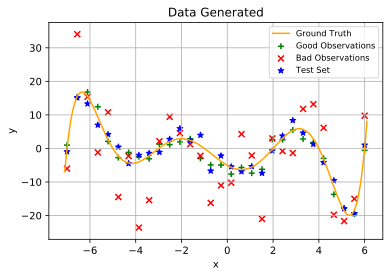

In [7]:
plt.title("Data Generated")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(X_true, y_true, label="Ground Truth", color="orange")
plt.scatter(X, y_obs, label="Good Observations", color="green", marker="+")
plt.scatter(X, y_obs_bad, label="Bad Observations", color="red", marker="x")
plt.scatter(X, y_test, label="Test Set", color="blue", marker="*")
plt.legend(prop=fontP)
plt.grid()

# 1. Ordinary Least Squares (OLS)
We'll begin with the standard least-squares problem. Given some data in the form of $(x, y)$ pairs, we wish to find the polynomial that will minimize the sum of the squared errors (SSE):

$$\min \sum_{i}(y_i - w^\top \vec{x}_i)^2 = \min_{\vec{w}} \|X\vec{w} - \vec{y}\|_2$$

Note that even though we are fitting a polynomial, the objective is still linear in the weights vector $\vec{w}$. This is because we create   features in the data matrix corresponding to higher order polynomial terms:

$$X = \begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_m \end{bmatrix} \rightarrow \hat{X} = \begin{bmatrix} x_1 & x_1^2 & \dots & x_1^d \\ x_2 & x_2^2 & \dots & x_2^d \\ \vdots \\ x_m & x_m^2 & \dots & x_m^d \end{bmatrix}$$

So now, each $w_i$ tunes the effect of adding an $i$th order term. This is known as $\textbf{lifting}$ the data into higher-dimensional space. Finding the "line" that regresses in this space is equivalent to finding the higher dimensional polynomial that actually fits the data.

Disclaimer: For this example, we will ignore the bad observations. We will return to that problem later.

### TODO: Implement OLS

In [8]:
def OLS(X, y, verbose=False):
    
    # TODO: Implement OLS 
    # Fill in the expressions for the pseudoinverse, X_dagger, and use that to compute the optimal w
    
    #----------
    
    X_dagger = np.linalg.inv(X.T @ X) @ X.T
    w = X_dagger @ y
    
    #----------
    error = np.linalg.norm(X @ w - y)
    
    if verbose:
        print("--------------------OLS-----------------------\n")
        print("The optimal w is", np.ndarray.flatten(w))
        print("\n")
        print("Training error:", error)
        print("\n")
    
    return w, error

In [9]:
w_ls, train_error_ls = OLS(X_hat, y_obs, verbose=True)
test_error_ls = np.linalg.norm(X_hat @ w_ls - y_test)
print("Testing error:", test_error_ls)

--------------------OLS-----------------------

The optimal w is [-6.626 -3.276  2.547  0.91  -0.206 -0.058  0.004  0.001]


Training error: 7.960973383711037


Testing error: 11.968690250941062


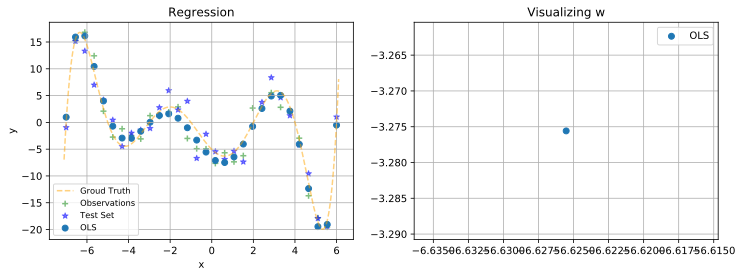

In [10]:
# Note that the 7 dimensional w is projected into two dimensions for plotting.
plot_result(X_hat, X, X_true, y_obs, y_true, y_test, [[w_ls, "OLS"]])

# 2. Ridge $(\ell_2)$ Regression
Vanilla least squares is great, but can be affected negatively by noise. Ordinary Least Squares (OLS) is susceptible to overfitting the data, since we only care about minimizing the squared error of the data we trained it on.

We can attempt to prevent this overfitting by introducing a penalty term on the weight vector. If we penalize it from getting too large (numerically unstable), we can combat the impact of noise. The penalty term we will use here is the $\ell_2$-norm:

$$\min_{\vec{w}} \|X\vec{w} - \vec{y}\|_2^2 + \lambda\|\vec{w}\|_2^2$$

### TODO: Implement Ridge Regression 

In [11]:
ridge_lmbda = None
#ridge_lambdas = np.logspace(-3, 3, 50)
ridge_lambdas = np.linspace(.0001,20, 10000)


def ridge(X, y, lmbda, verbose=False):
    
    # TODO: Implement Ridge Regression
    
    #----------
    
    X_dagger = np.linalg.inv(X.T @ X + lmbda * np.eye(X.shape[1])) @ X.T
    w = X_dagger @ y
    
    #----------
    error = np.linalg.norm(X @ w - y)
    
    if verbose:
        print("--------------------Ridge-----------------------\n")
        print("Lambda: ", lmbda)
        print("\n")
        print("The optimal w is", np.ndarray.flatten(w))
        print("\n")
        print("Training error:", error)
        print("\n")
        
    return w, error

## 2.1. Hyperparmater Tuning
One thing to note is the $\lambda$ in the problem. It is known as a $\textbf{hyperparameter}$ and must be manually tuned, since we don't really know how much to penalize the norm. In order to find the best $\lambda$ we test different values and see how well the learned model generalizes by computing the squared  error of the predictions of our model on unseen test data. Below, you can see the effect of different values of $\lambda$ on the SSE for the training data, the SSE for the test data, and the components of $\vec{w}$.

In [12]:
train_errors_rr = []
test_errors_rr = []
ws_rr = []
for l in ridge_lambdas:
    w_rr, train_error_rr = ridge(X_hat, y_obs, l)
    test_error_rr = np.linalg.norm(X_hat @ w_rr - y_test)
    train_errors_rr.append(train_error_rr)
    ws_rr.append(w_rr)
    test_errors_rr.append(test_error_rr)

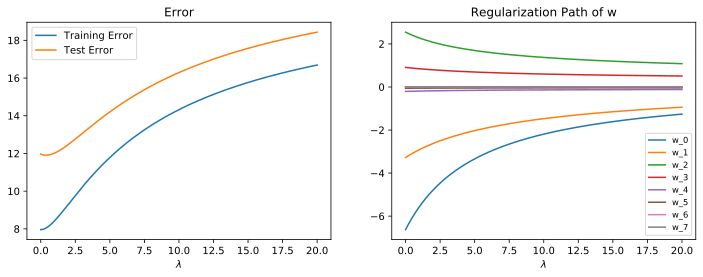

In [13]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.title("Error")
plt.xlabel(r"$\lambda$")
#plt.xscale("log")
plt.plot(ridge_lambdas, train_errors_rr, label="Training Error")
plt.plot(ridge_lambdas, test_errors_rr, label="Test Error")
plt.legend()

fig.add_subplot(122)
plt.title("Regularization Path of w")
num_coeffs = len(ws_rr[0])
plt.xlabel(r"$\lambda$")
#plt.xscale("log")
for i in range(num_coeffs):
    plt.plot(ridge_lambdas, [w[i][0] for w in ws_rr], label="w_" + str(i))
plt.legend(prop=fontP)

### TODO: What do you observe in the graphs above? Why does increasing $\lambda$ lead to these trends in the training error, testing error, and weights?

In [14]:
# TODO: Try changing these values, what do you see?
test_lmbdas = [.1, 1, 2, 100] 

In [15]:
w_rrs = []
for l in test_lmbdas:
    w_rr, train_error_rr = ridge(X_hat, y_obs, l, verbose=True)
    test_error_rr = np.linalg.norm(X_hat @ w_rr - y_test)
    print("Testing error:", test_error_rr)
    print("\n")
    w_rrs.append([w_rr, r"$\lambda:$" + str(l)])
w_rrs.append([w_ls, "OLS"])

--------------------Ridge-----------------------

Lambda:  0.1


The optimal w is [-6.502 -3.235  2.515  0.902 -0.204 -0.058  0.004  0.001]


Training error: 7.967400962584387


Testing error: 11.939903920447648


--------------------Ridge-----------------------

Lambda:  1


The optimal w is [-5.559 -2.91   2.276  0.846 -0.19  -0.055  0.004  0.001]


Training error: 8.42868197325854


Testing error: 12.017057009517758


--------------------Ridge-----------------------

Lambda:  2


The optimal w is [-4.779 -2.622  2.075  0.796 -0.178 -0.053  0.004  0.001]


Training error: 9.306024166900063


Testing error: 12.47863980780172


--------------------Ridge-----------------------

Lambda:  100


The optimal w is [-0.228 -0.204  0.564  0.364 -0.08  -0.031  0.002  0.001]


Training error: 20.11540062310062


Testing error: 21.913802883969474




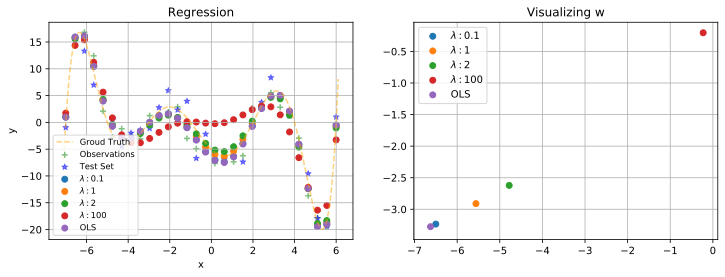

In [16]:
plot_result(X_hat, X, X_true, y_obs, y_true, y_test, w_rrs)

### TODO: How does changing $\lambda$ affect the regressor?

# 3. Weighted Least Squares (WLS)
Sometimes, our data observations $X$ may not be trustworthy. Perhaps multiple sources gathered data, but one is very noisy. How can we account for this? We can just weight each of the data points!
$$\min_{\vec{w}} \|W_1(X\vec{w} - \vec{y})\|_2$$
$$W_1 = diag(w_1, w_2, \dots)$$

To show the usefulness, we can compare how OLS would react to this extra "bad" data versus WLS.

In [17]:
# append bad data to data matrix
X_hat_with_bad = np.vstack((X_hat, X_hat))
y_with_bad = np.vstack((y_obs, y_obs_bad))

### TODO: Implement WLS 

In [18]:
def WLS(X, y, W_vec, verbose=False):
    
    W = np.diag(W_vec)
    
    # TODO: Implement WLS using the pseudoinverse
    #----------
    
    X_bar = W @ X
    y_bar = W @ y
    X_dagger = np.linalg.inv(X_bar.T @ X_bar) @ X_bar.T
    w = X_dagger @ y_bar
    
    #----------
    error = np.linalg.norm(X @ w - y)
    
    if verbose:
        print("--------------------WLS-----------------------")
        print("\n")
        print("The optimal w is", np.ndarray.flatten(w))
        print("\n")
        print("Training error:", error)
        print("\n")
    
    return w, error

In [19]:
# Choose appropriate data weight vector (this will eventually become a diagonal matrix)
# We only trust the first half of the data more than the second half

wls_W1_vec = np.concatenate((np.ones(X.shape[0]), 0.5*np.ones(X.shape[0])))

In [20]:
w_ls_bad, train_error_ls_bad = OLS(X_hat_with_bad, y_with_bad, verbose=True)
test_error_ls_bad = np.linalg.norm(X_hat @ w_ls_bad - y_test)
print("Testing error:", test_error_ls_bad)
print("\n")

w_wls, train_error_wls = WLS(X_hat_with_bad, y_with_bad, wls_W1_vec, verbose=True)
test_error_wls = np.linalg.norm(X_hat @ w_wls - y_test)
print("Testing error:", test_error_wls)
print("\n")

w_wls = [[w_wls, "WLS"], [w_ls_bad, "OLS w/ Bad Data"]]

--------------------OLS-----------------------

The optimal w is [-7.956 -4.962  2.974  1.339 -0.247 -0.08   0.005  0.001]


Training error: 48.31421272535342


Testing error: 17.503745407090697


--------------------WLS-----------------------


The optimal w is [-7.158 -3.95   2.718  1.081 -0.223 -0.067  0.004  0.001]


Training error: 49.58883053091355


Testing error: 12.919204634462229




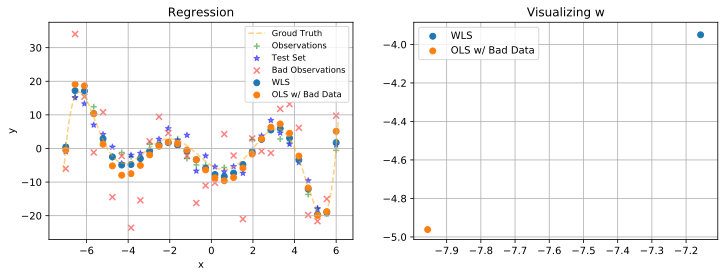

In [21]:
plot_result(X_hat, X, X_true, y_obs, y_true, y_test, w_wls, y_obs_bad=y_obs_bad)

## 3.1 WLS Playground (optional)

We used a very straightforward approach in how we treated the validity of the data. But it didn't turn out to work that well! The training error of OLS was actually pretty good compared to WLS, so perhaps stricly ignoring the data isn't the best choice. Now it's your turn to play around with different $W_1$ values. See what happens when you choose different ones!

--------------------WLS-----------------------


The optimal w is [-6.626 -3.276  2.547  0.91  -0.206 -0.058  0.004  0.001]


Training error: 51.777400062701176


Testing error: 11.968690250941059




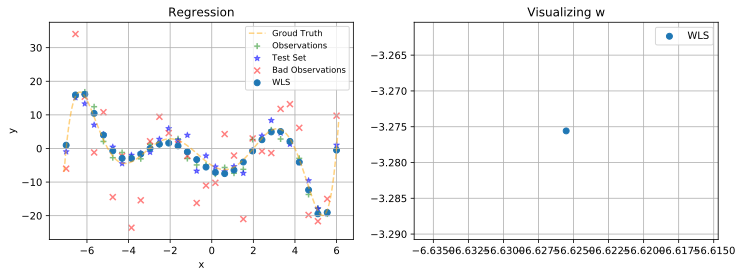

In [22]:
# Choose appropriate data weight vector (this will eventually become a diagonal matrix)

# TODO: play around with this vector and see the results
#----------

wls_W1_vec = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))

#----------

w_wls, train_error_wls = WLS(X_hat_with_bad, y_with_bad, wls_W1_vec, verbose=True)
test_error_wls = np.linalg.norm(X_hat @ w_wls - y_test)
print("Testing error:", test_error_wls)
print("\n")

w_wls = [[w_wls, "WLS"]]

plot_result(X_hat, X, X_true, y_obs, y_true, y_test, w_wls, y_obs_bad=y_obs_bad)

### TODO (optional): What $W_1$s did you try? How did they affect the regressor?

# 4. Tikhonov Regularization

Tikhonov regularization is the combination of everything we've seen so far: ordinary least squares (OLS), giving weight to each sample via the $W_1$ matrix, and $\ell_2$-norm penalization. However, we can also generalize the last penalty: instead of one $\lambda$, use another another matrix $W_2$ that gives penalization weights to each element. For example, if we really cared about only allowing low-order polynomial terms, we would $\textit{decrease}$ the weights on the first few $w_i$s, as we don't wish to penalize "using" those. Putting this all together, we get the following form:

$$\min_{\vec{w}} \|W_1(X\vec{w} - \vec{y})\|_2^2+ \|W_2(\vec{w} - \vec{w_0})\|_2^2$$
$$W_1 = diag(w_1, w_2, \dots), W_2 = diag(\lambda_1, \lambda_2, \dots)$$

One thing that may seem new is the $\vec{w} - \vec{w_0}$ term. To understand this, consider what we saw before: we just penalized the vector $\vec{w}$, meaning that the longer $\vec{w}$ was from the origin, the higher the penalty. However, we can generalize this as well: instead, we can penalize how far it is from some predetermined "center" $\vec{w_0}$.

Since this is the most robust method, we will juxtapose it with the performance of all methods seen so far on the entire good + bad dataset.

### TODO: Try out Tikhonov Regularization 

In [23]:
def tikhonov(X, y, W1_vec, W2_vec, w_0, verbose=False):
    
    W1 = np.diag(W1_vec)
    W2 = np.diag(W2_vec)
    #----------
    
    X_bar = W1 @ X
    y_bar = W1 @ y
    w_0_bar = (W2 @ w_0).reshape(-1, 1)
    
    X_tilde = np.linalg.inv(X_bar.T @ X_bar + W2.T @ W2)
    w = X_tilde @ (X_bar.T @ y + W2.T @ w_0_bar)
    
    #----------
    error = np.linalg.norm(X @ w - y)
    
    if verbose:
        print("--------------------Tikhonov-----------------------\n")
        print("The optimal w is", np.ndarray.flatten(w))
        print("\n")
        print("Training error:", error)
        print("\n")

    return w, error

In [24]:
w_ls_bad, train_error_ls_bad = OLS(X_hat_with_bad, y_with_bad, verbose=True)
test_error_ls_bad = np.linalg.norm(X_hat @ w_ls_bad - y_test)
print("Testing error:", test_error_ls_bad)
print("\n")

# Ridge
ridge_lmbda = 10
w_rr_bad, train_error_rr_bad = ridge(X_hat_with_bad, y_with_bad, ridge_lmbda, verbose=True)
test_error_rr = np.linalg.norm(X_hat @ w_rr_bad - y_test)
print("Testing error:", test_error_rr)
print("\n")


# WLS: Only trust first half of data
W1_vec = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))
w_wls, train_error_wls = WLS(X_hat_with_bad, y_with_bad, W1_vec, verbose=True)
test_error_wls = np.linalg.norm(X_hat @ w_wls - y_test)
print("Testing error:", test_error_wls)
print("\n")

# Tikhonov:
# Constant weights on all terms
W2_vec = np.ones(X_hat.shape[1]) * 10

# Penalize distance to origin
w_0 = np.zeros(X_hat.shape[1])

w_tikh, train_error_tikh = tikhonov(X_hat_with_bad, y_with_bad, W1_vec, W2_vec, w_0, verbose=True)
test_error_tikh = np.linalg.norm(X_hat @ w_tikh - y_test)
print("Testing error:", test_error_tikh)
print("\n")

w_final = [[w_ls_bad, "OLS"], [w_rr_bad, "Ridge"], [w_wls, "WLS"], [w_tikh, "Tikhonov"]]

--------------------OLS-----------------------

The optimal w is [-7.956 -4.962  2.974  1.339 -0.247 -0.08   0.005  0.001]


Training error: 48.31421272535342


Testing error: 17.503745407090697


--------------------Ridge-----------------------

Lambda:  10


The optimal w is [-3.992 -3.138  1.931  1.034 -0.184 -0.066  0.004  0.001]


Training error: 50.72596758744696


Testing error: 17.10766535536566


--------------------WLS-----------------------


The optimal w is [-6.626 -3.276  2.547  0.91  -0.206 -0.058  0.004  0.001]


Training error: 51.777400062701176


Testing error: 11.968690250941059


--------------------Tikhonov-----------------------

The optimal w is [-0.228 -0.204  0.564  0.364 -0.08  -0.031  0.002  0.001]


Training error: 61.50425763462563


Testing error: 21.9138028839692




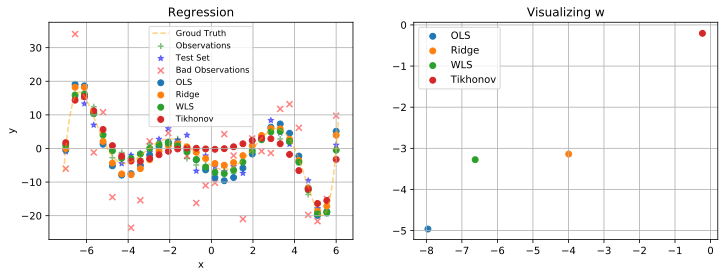

In [25]:
plot_result(X_hat, X, X_true, y_obs, y_true, y_test, w_final, y_obs_bad=y_obs_bad)

## 4.1 Weighting Polynomial Features (optional)
Using Tikhonov regularization, we have great control over how we want our regressor to end up. Don't like some of the data? Specify $W_1$ matrix to down weight such data. Interested in only allowing certain polynomial orders? Specify $W_2$ matrix to prefer such features. Below, you can see the result of designing the $W_2$ matrix to control the degree of our regressor.

In [26]:
def degree_control(highest_degree_desired):
    # off-by-one due to existence of 0 degree terms
    allowed = np.ones(highest_degree_desired + 1)
    disallowed = np.ones(X_hat.shape[1] - (highest_degree_desired + 1)) * 10**15
    return np.concatenate((allowed, disallowed))

--------------------Tikhonov-----------------------

The optimal w is [-1.085 -0.     0.    -0.     0.    -0.     0.    -0.   ]


Training error: 83.41462636053734


Testing error: 40.97672938611055




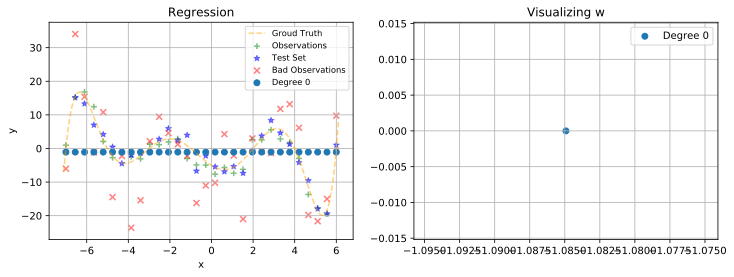

--------------------Tikhonov-----------------------

The optimal w is [-1.655 -1.178  0.    -0.     0.    -0.     0.    -0.   ]


Training error: 79.01519349230902


Testing error: 34.93426010707218




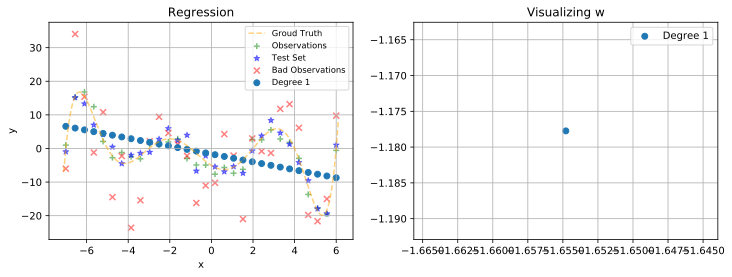

--------------------Tikhonov-----------------------

The optimal w is [-2.36  -1.128  0.049 -0.     0.    -0.     0.    -0.   ]


Training error: 78.34751103282318


Testing error: 35.044352007789804




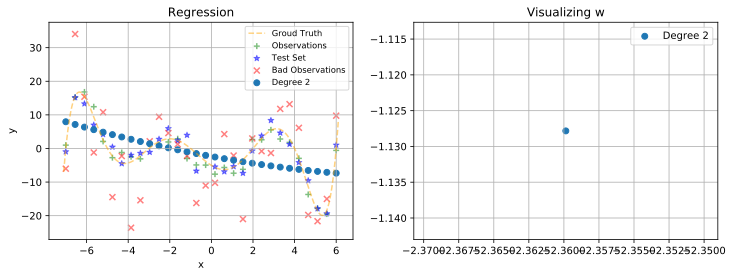

--------------------Tikhonov-----------------------

The optimal w is [-1.761  0.13  -0.021 -0.048 -0.     0.    -0.     0.   ]


Training error: 75.81873278370045


Testing error: 33.901511650158184




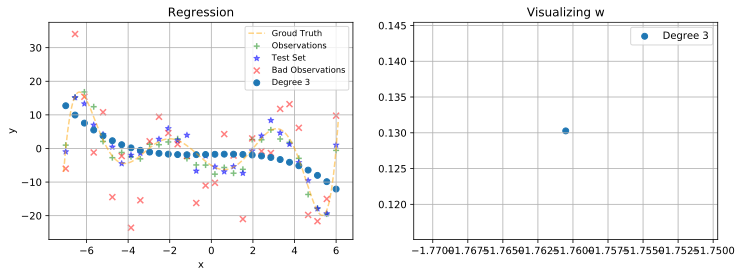

--------------------Tikhonov-----------------------

The optimal w is [-2.696  0.365  0.204 -0.06  -0.006  0.    -0.     0.   ]


Training error: 75.85092163710165


Testing error: 33.61556589588734




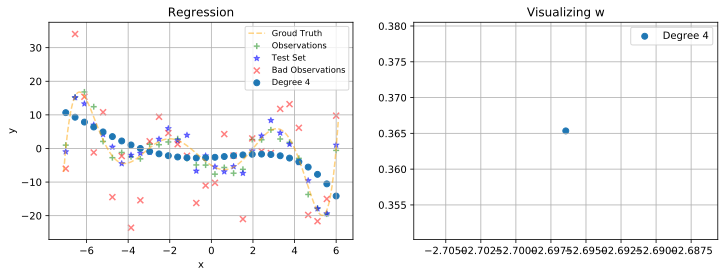

--------------------Tikhonov-----------------------

The optimal w is [-1.959  1.894 -0.047 -0.226  0.003  0.004  0.     0.   ]


Training error: 74.49266145963905


Testing error: 32.84739763269132




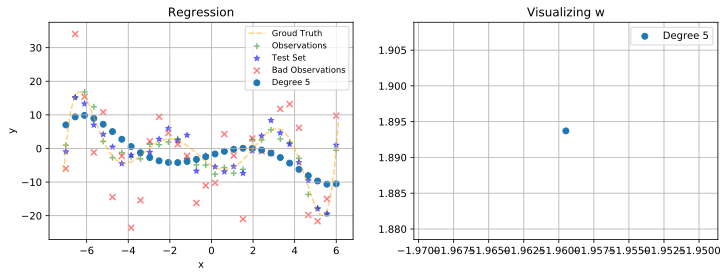

--------------------Tikhonov-----------------------

The optimal w is [-2.881  2.415  0.437 -0.298 -0.032  0.005  0.001  0.   ]


Training error: 74.24479750985645


Testing error: 32.22149978734026




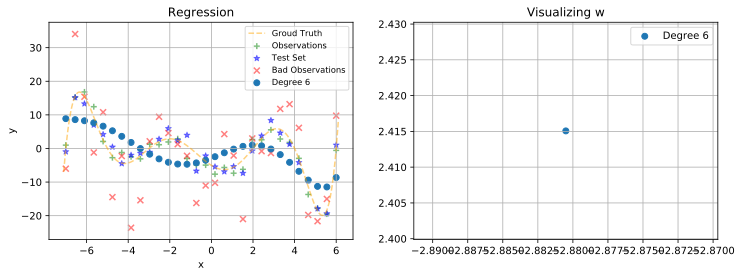

--------------------Tikhonov-----------------------

The optimal w is [-5.559 -2.91   2.276  0.846 -0.19  -0.055  0.004  0.001]


Training error: 52.448156722250005


Testing error: 12.017057009521244




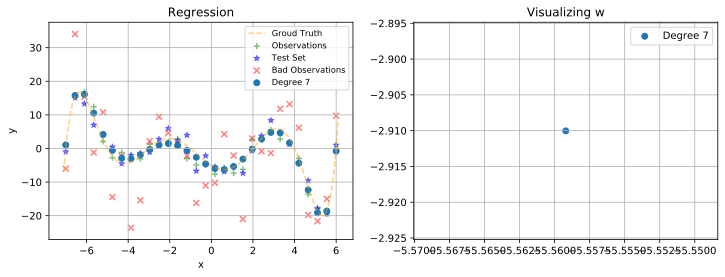

In [27]:
for highest_degree in np.arange(X_hat.shape[1]):
    W2_vec = degree_control(highest_degree)
    w_tikh, train_error_tikh = tikhonov(X_hat_with_bad, y_with_bad, W1_vec, W2_vec, w_0, verbose=True)
    test_error_tikh = np.linalg.norm(X_hat @ w_tikh - y_test)
    print("Testing error:", test_error_tikh)
    print("\n")
    w_tikh_w2 = [[w_tikh, "Degree " + str(highest_degree)]]
    plot_result(X_hat, X, X_true, y_obs, y_true, y_test, w_tikh_w2, y_obs_bad=y_obs_bad)
    plt.show()

## 4.2 Tikhonov Playground (optional)

Now that you have 3 hyperparameters, $W_1, W_2, \vec{w}_0$, there is so much fun to be had! Try out different values and see how it affects your regressor!

In [28]:
# TODO: change these values to see what happens!

W1_vec = np.concatenate((np.ones(X.shape[0]), np.zeros(X.shape[0])))

W2_vec = np.ones(X_hat.shape[1]) * 10

w_0 = np.zeros(X_hat.shape[1])

--------------------Tikhonov-----------------------

The optimal w is [-0.228 -0.204  0.564  0.364 -0.08  -0.031  0.002  0.001]


Training error: 61.50425763462563


Testing error: 21.9138028839692




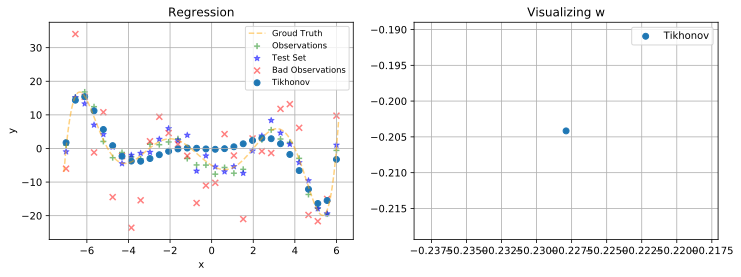

In [29]:
w_tikh, train_error_tikh = tikhonov(X_hat_with_bad, y_with_bad, W1_vec, W2_vec, w_0, verbose=True)
test_error_tikh = np.linalg.norm(X_hat @ w_tikh - y_test)
print("Testing error:", test_error_tikh)
print("\n")
w_tikh = [[w_tikh, "Tikhonov"]]
plot_result(X_hat, X, X_true, y_obs, y_true, y_test, w_tikh, y_obs_bad=y_obs_bad)

### TODO (optional): What hyperparmaters did you try? How did they affect the regressor?

# 5. Extra Things to Try (optional)

Now that you've seen these methods in action, try and play around with different values. Some suggestions are to change data_fn() to generate a different set of data, or change the poly_degree argument in generate_data() to choose a different order polynomial regressor. It may be interesting to see what happens if you choose the data_fn() to be a lower order than the polynomial trying to fit it. There, overfitting will be on full display.